In [33]:
import time
import glob
import re
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import itertools

import networkx as nx
from networkx.algorithms import bipartite

import email

import pylab
from colour import Color
from pylab import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from bigbang import listserv
from bigbang.analysis.listserv import ListservArchive
from bigbang.analysis.listserv import ListservList
from bigbang.visualisation import graphs
from bigbang.visualisation import lines

from config.config import CONFIG

plt.style.use("publication_jcap.mplstyle")

In [46]:
# 3GPP_TSG_RAN_WG5_5G_NR 3GPP_TSG_RAN_WG4_IOT 3GPP_TSG_RAN_WG5_IOT 3GPP_TSG_CT_WG1_122E_5G
# 3GPP_TSG_SA_WG1 3GPP_TSG_SA_WG2 3GPP_TSG_SA_WG3 3GPP_TSG_SA_WG4 3GPP_TSG_SA_WG5 3GPP_TSG_SA_WG6
mlist_name = "3GPP_TSG_CT_WG1_122E_5G"
mlist = ListservList.from_mbox(
    name=mlist_name,
    filepath=f"/home/christovis/InternetGov/bigbang/archives/3GPP/{mlist_name}.mbox",
    include_body=True,
)

mlist.df = mlist.df[mlist.df['from'].notna()]
mlist.df = mlist.df[mlist.df['comments-to'].notna()]

standard_release_info = pd.read_csv(
    "/home/christovis/InternetGov/bigbang/bigbang/analysis/3GPP_standards_release_dates.csv",
    sep=",",
    header=2,
    index_col=False,
)
standard_release_info['Start date'] =  pd.to_datetime(standard_release_info['Start date'], format='%Y-%m-%d')
standard_release_year = [dt.year for dt in standard_release_info['Start date']]

eifs = [
    "huawei.com",
    "huawei.comcc",
    "huawei.com.cn",
    "notesmail.huawei.com.cn",
    "in.huawei.com",
    "tencent.com",
    "xiaomi.com",
    "chinamobile.com",
    "cmdi.chinamobile.com",
    "bj.chinamobile.com",
    "hisilicon.comzte.com.cn",
    "chinatelecom.cn",
    "chinaunicom.cn",
    "catt.cn",
    "catt.ac.cn",
    "caict.ac.cn",
]

# Integrated Time

In [47]:
def format_dictionary(dic: dict, threshold: Union[int, float]) -> dict:
    dic_sorted = {list(dic.keys())[indx]: list(dic.values())[indx] for indx in np.argsort(list(dic.values()))[::-1]}

    percentages = ListservList.to_percentage(list(dic_sorted.values()))
    dic_sorted = {key: value for key, value in zip(dic_sorted.keys(), percentages)}

    dic_filtered = {"others": []}
    
    if isinstance(threshold, int):
        for index, (key, value) in enumerate(dic_sorted.items()):
            if index <= threshold:
                dic_filtered[key] = value
            else:
                dic_filtered["others"].append(value)
    elif isinstance(threshold, float):
        for key, value in dic_sorted.items():
            if value >= threshold:
                dic_filtered[key] = value
            else:
                dic_filtered["others"].append(value)
    return dic_filtered

In [48]:
mlist.create_sender_receiver_digraph()

dic_bc = nx.betweenness_centrality(mlist.dg, weight="weight")
dic_cc = nx.closeness_centrality(mlist.dg)
dic_dc = nx.degree_centrality(mlist.dg)

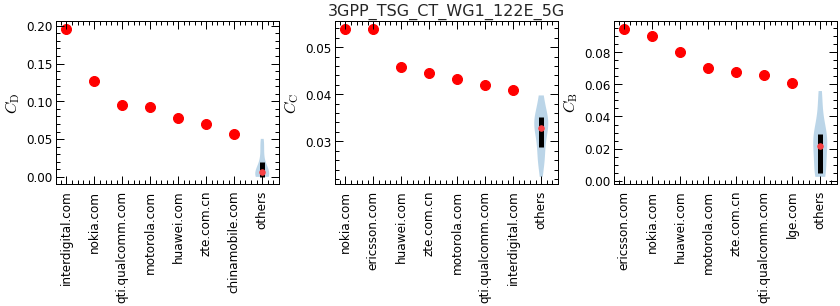

In [49]:
fig, axis = plt.subplots(
    1, 3,
    figsize=(14, 3),
    sharex=False, sharey=False,
    facecolor="w", edgecolor="k",
)
fig.subplots_adjust(
    hspace=0.05,
    wspace=0.25,
)

threshold = 6
dict_filtered = format_dictionary(dic_bc, threshold)
data_others = dict_filtered["others"]
del dict_filtered['others']
ind_length = len(dict_filtered.keys())
ind = np.arange(ind_length)
quartile1, median, quartile3 = np.percentile(data_others, [25, 50, 75])

axis[0].scatter(
    ind,
    dict_filtered.values(),
    color='r',
)
axis[0].violinplot(
    data_others,
    positions=[ind_length],
    showmeans=False,
    showmedians=False,
    showextrema=False,
)
axis[0].scatter(ind_length, median, marker='o', color=Color(rgb=(np.array([249, 65, 68])/255)).rgb, s=30, zorder=3)
axis[0].vlines(ind_length, quartile1, quartile3, color='k', linestyle='-', lw=5)

axis[0].set_xticks(np.arange(len(dict_filtered.items()) + 1))
axis[0].set_xticklabels(list(dict_filtered.keys()) + ["others"], rotation=90,)

dict_filtered = format_dictionary(dic_cc, threshold)
data_others = dict_filtered["others"]
del dict_filtered['others']
ind_length = len(dict_filtered.keys())
ind = np.arange(ind_length)
quartile1, median, quartile3 = np.percentile(data_others, [25, 50, 75])

axis[1].scatter(
    ind,
    dict_filtered.values(),
    color='r',
)
axis[1].violinplot(
    data_others,
    positions=[ind_length],
    showmeans=False,
    showmedians=False,
    showextrema=False,
)
axis[1].scatter(ind_length, median, marker='o', color=Color(rgb=(np.array([249, 65, 68])/255)).rgb, s=30, zorder=3)
axis[1].vlines(ind_length, quartile1, quartile3, color='k', linestyle='-', lw=5)

axis[1].set_xticks(np.arange(len(dict_filtered.items()) + 1))
axis[1].set_xticklabels(list(dict_filtered.keys()) + ["others"], rotation=90,)

dict_filtered = format_dictionary(dic_dc, threshold)
data_others = dict_filtered["others"]
del dict_filtered['others']
ind_length = len(dict_filtered.keys())
ind = np.arange(ind_length)
quartile1, median, quartile3 = np.percentile(data_others, [25, 50, 75])

axis[2].scatter(
    ind,
    dict_filtered.values(),
    color='r',
)
axis[2].violinplot(
    data_others,
    positions=[ind_length],
    showmeans=False,
    showmedians=False,
    showextrema=False,
)
axis[2].scatter(ind_length, median, marker='o', color=Color(rgb=(np.array([249, 65, 68])/255)).rgb, s=30, zorder=3)
axis[2].vlines(ind_length, quartile1, quartile3, color='k', linestyle='-', lw=5)

axis[2].set_xticks(np.arange(len(dict_filtered.items()) + 1))
axis[2].set_xticklabels(list(dict_filtered.keys()) + ["others"], rotation=90,)

axis[1].set_title(mlist_name)
axis[0].set_ylabel(r'$C_{\rm D}$')
axis[1].set_ylabel(r'$C_{\rm C}$')
axis[2].set_ylabel(r'$C_{\rm B}$')

#"""
plt.savefig(
    f"connectivity_domain_{mlist_name}.png",
    format='png',
    transparent=True,
    dpi=300,
    bbox_inches='tight',
)#"""

# Time Derivative

In [3]:
dic_bc = mlist.get_graph_prop_per_domain_per_year(func=nx.betweenness_centrality, **{"weight": "weight"})
dic_cc = mlist.get_graph_prop_per_domain_per_year(func=nx.closeness_centrality)
dic_dg = mlist.get_graph_prop_per_domain_per_year(func=nx.degree_centrality)

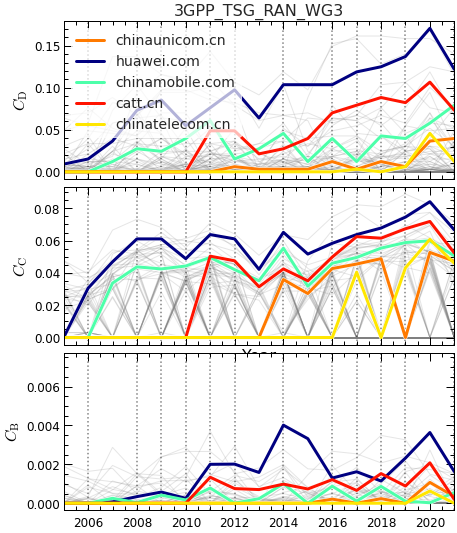

In [4]:
fig, axis = plt.subplots(
    3, 1,
    figsize=(7, 9),
    sharex=True, sharey='row',
    facecolor="w", edgecolor="k",
)
fig.subplots_adjust(
    hspace=0.05,
    wspace=0.0,
)

lines.evolution_of_graph_property_by_domain(
    dic_dg,
    "year",
    "degree_centrality",
    entity_in_focus=eifs,
    ax=axis[0],
)
lines.evolution_of_graph_property_by_domain(
    dic_cc,
    "year",
    "closeness_centrality",
    entity_in_focus=eifs,
    ax=axis[1],
)
lines.evolution_of_graph_property_by_domain(
    dic_bc,
    "year",
    "betweenness_centrality",
    entity_in_focus=eifs,
    ax=axis[2],
)
for yr in standard_release_year:
    axis[0].axvline(x=yr, linestyle=':', color='k', alpha=0.5, zorder=0)
    axis[1].axvline(x=yr, linestyle=':', color='k', alpha=0.5, zorder=0)
    axis[2].axvline(x=yr, linestyle=':', color='k', alpha=0.5, zorder=0)

axis[0].set_xlim(2005, 2021)
axis[1].set_xlim(2005, 2021)
axis[2].set_xlim(2005, 2021)

axis[0].set_title(mlist_name)
axis[1].set_xlabel('Year')
axis[0].set_ylabel(r'$C_{\rm D}$')
axis[1].set_ylabel(r'$C_{\rm C}$')
axis[2].set_ylabel(r'$C_{\rm B}$')
axis[0].legend(loc=2, edgecolor='white', facecolor='white', framealpha=0.7)

#"""
plt.savefig(
    f"connectivity_domain_{mlist_name}.png",
    format='png',
    transparent=True,
    dpi=300,
    bbox_inches='tight',
)#"""

## Testing Scale-free Graph

In [5]:
dic_graph = mlist.get_sender_receiver_dictionary()#domains_in_focus=coi)
mlist.create_sender_receiver_digraph(nw=dic_graph)

[]

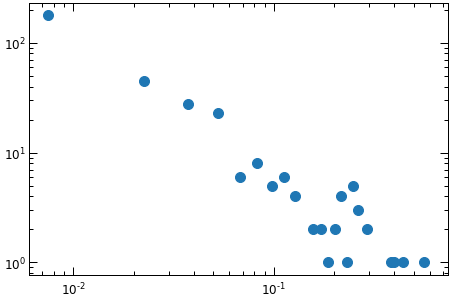

In [6]:
adj = nx.degree_centrality(mlist.dg)

hist, bin_edges = np.histogram(list(adj.values()), bins=40, range=(0.0, 0.6))
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.scatter(bin_centres, hist)
plt.loglog()

## Create Graph

In [3]:
dic_graph = mlist.get_sender_receiver_dictionary()#domains_in_focus=coi)
mlist.create_sender_receiver_digraph(nw=dic_graph, entity_in_focus=eifs)

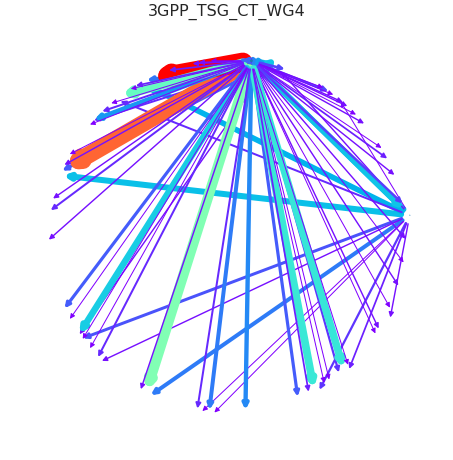

In [14]:
edges, edge_width = graphs.edge_thickness(mlist.dg, entity_in_focus=eifs)
node_size = graphs.node_size(mlist.dg)
#node_label = [lab for lab in list(adj.keys()) if lab in coi]

#pos = nx.spring_layout(mlist.dg)
pos = nx.shell_layout(mlist.dg)
#pos = nx.kamada_kawai_layout(mlist.dg)

fig, axis = plt.subplots(
    1, 1,
    sharex=False, sharey=False,
    figsize=(8, 8),
    facecolor="w", edgecolor="w",
)

nx.draw_networkx_nodes(
    mlist.dg, pos,
    #node_color='b',
    node_size=node_size,
    #alpha=1/(node_size)**(1/4),
)

nx.draw_networkx_edges(
    mlist.dg, pos,
    width=edge_width,
    edgelist=edges,
    edge_color=edge_width,
    edge_cmap=plt.cm.rainbow,
)

plt.title(mlist_name)
plt.axis('off')

"""
nx.draw_networkx_labels(
    mlist.dg, pos,
    node_label,
    font_size=18, 
    font_color='r',
)
"""
#"""
plt.savefig(
    f"graphs_{mlist_name}.png",
    format='png',
    transparent=True,
    dpi=300,
    bbox_inches='tight',
)#"""

# Clustering coefficient

In [9]:
def find_cliques_size_k(G, k):
    i = 0
    for clique in nx.find_cliques(G):
        if len(clique) == k:
            i += 1
        elif len(clique) > k:
            i += len(list(itertools.combinations(clique, k)))
    return i

In [10]:
G = DG.to_undirected()
find_cliques_size_k(G, 6)

NameError: name 'DG' is not defined

# Spectral_bipartivity

We do indeed find functional structure in both the
national and the regional company-level production networks.
Compared to randomized versions of itself, the reconstructed
regional network has significantly higher spectral bipartivity
[Kolmogorov-Smirnov (KS) statistic 1.0, N1 = 1, N2 = 1, 000,
p < 0.001]. The value itself remains much smaller than 1,
indicating that the network structure is definitely not bipartite
as would be the case if it were a two-mode network. Small values
then let us approximate the logit-transformed spectral bipartivity
and extend our results to the larger Netherlands network. This
measure is again higher than expected (KS = 1.0, N1 = 1,
N2 = 25, p < 0.04) indicating functional structure.

In [ ]:
bipartite.spectral_bipartivity(DG)

# Degree centrality

Complementarily, variables with high closeness have
shortest paths to many other variables in the CLD with
a short distance, i.e., few mediating variables, render-
ing them potentially efficient spreaders of information
(Ahmed 2017).

For network processes, a typical initial analysis is to identify structurally important, or “central”, variables. Such an analysis can also help pinpoint central drivers of disease in CLDs (McGlashan et al. 2016). To this end, we calculated the betweenness centrality (BC) and closeness centrality (CC) for each of the variables in the CLD.

To assess whether networks have functional structure, we repurpose an existing measure that captures a distinctive feature of local connectivity in functional networks. Link prediction performance on PPI networks suggests that three-step closure is more common than two-step closure (Kovács et al., 2019). That is, closed squares are more prominent than are closed triangles. We measure this using spectral bipartivity, which quantifies the abundance of even vs. odd cycles in a network’s local connectivity structure (Estrada and Gómez-Gardeñes, 2016), in comparison to random expectation; functional networks have higher-than-random spectral bipartivity.

Spectral bipartivity, a measure that quantifies the over-representation of even paths in these networks.